# Microphone Recorder

This Jupyter notebook demonstrates how to record audio using a microphone and save the recording as a WAV file. We use the `pyaudio` library for capturing audio data. This example includes classes for managing the recording process, saving files, and playback.

## Prerequisites

Before running the notebook, ensure you have the necessary packages installed:

In [1]:
# Installing necessary packages
%pip install pyaudio scipy matplotlib faster-whisper pydub simpleaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:


import pyaudio
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import time
from tkinter import TclError

# use this backend to display in separate Tk window
%matplotlib tk

# constants
CHUNK = 1024 * 2             # samples per frame
FORMAT = pyaudio.paInt16     # audio format (bytes per sample?)
CHANNELS = 1                 # single channel for microphone
RATE = 44100                 # samples per second

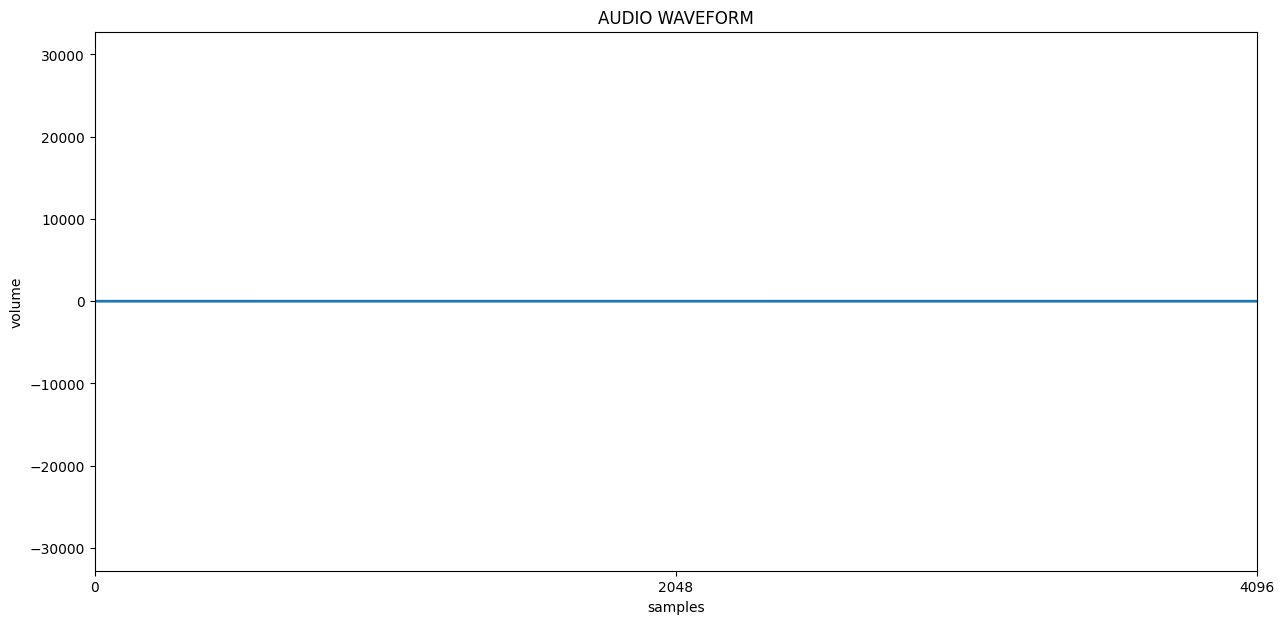

Playing audio


NameError: name 'TclError' is not defined

In [1]:
# create matplotlib figure and axes
fig, ax = plt.subplots(1, figsize=(15, 7))

# pyaudio class instance
p = pyaudio.PyAudio()

# stream object to get data from microphone
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    input_device_index=3,
    output=True,
    frames_per_buffer=CHUNK,
)

# variable for plotting
x = np.arange(0, 2 * CHUNK, 2)

# create a line object with random data
(line,) = ax.plot(x, np.random.rand(CHUNK), "-", lw=2)

# basic formatting for the axes
ax.set_title("AUDIO WAVEFORM")
ax.set_xlabel("samples")
ax.set_ylabel("volume")
ax.set_ylim(0, 255)
ax.set_xlim(0, 2 * CHUNK)
plt.setp(ax, xticks=[0, CHUNK, 2 * CHUNK], yticks=[0, 128, 255])

# show the plot
plt.show(block=False)

print("stream started")

# for measuring frame rate
frame_count = 0
start_time = time.time()

while True:

    # binary data
    data = stream.read(CHUNK)

    # convert data to integers, make np array, then offset it by 127
    data_int = struct.unpack(str(2 * CHUNK) + "B", data)

    # create np array and offset by 128
    data_np = np.array(data_int, dtype="b")[::2] + 128

    line.set_ydata(data_np)

    # update figure canvas
    try:
        fig.canvas.draw()
        fig.canvas.flush_events()
        frame_count += 1

    except TclError:

        # calculate average frame rate
        frame_rate = frame_count / (time.time() - start_time)

        print("stream stopped")
        print("average frame rate = {:.0f} FPS".format(frame_rate))
        break

In [ ]:
# Importing necessary libraries
import pyaudio
import wave
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write
from faster_whisper import WhisperModel

In [ ]:
# Choose your model settings
model_size = "medium"
model = WhisperModel(
    model_size, device="cpu", compute_type="int8"
)  # Use "cpu" if CUDA is not available

In [ ]:
# Initialize PyAudio
p = pyaudio.PyAudio()

# Get and print the list of available input devices along with the number of channels
input_devices = []
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)
    if device_info["maxInputChannels"] > 0:
        input_devices.append((i, device_info["name"], device_info["maxInputChannels"]))
        print(
            f"Device ID {i}: {device_info['name']} - Channels: {device_info['maxInputChannels']}"
        )

Device ID 1: Galaxy Buds2 Pro - Channels: 1
Device ID 3: MacBook Pro Microphone - Channels: 1
Device ID 5: Gabriel’s iPhone Microphone - Channels: 1
Device ID 6: Microsoft Teams Audio - Channels: 2


In [ ]:
# Prompt the user to select a device by entering the device ID
selected_device_id = int(
    input("Enter the Device ID of the input device you want to use: ")
)

# Retrieve the number of channels for the selected device
selected_device_info = next(
    (device for device in input_devices if device[0] == selected_device_id), None
)
if selected_device_info:
    selected_channels = selected_device_info[2]
    print(f"Selected Device ID: {selected_device_id}, Channels: {selected_channels}")
else:
    print("Invalid Device ID")

Selected Device ID: 3, Channels: 1


In [ ]:
import wave
import os

# Audio recording parameters
RATE = 16000  # Sample rate
CHANNELS = (
    selected_channels  # Use the number of channels available on the selected device
)
CHUNK = 1024  # Buffer size
FORMAT = pyaudio.paInt16  # Audio format
duration = 30  # Duration of recording in seconds

In [ ]:
# Directory for saving recordings
folder_name = "mp3_audio_files"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
# Start audio recording
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    input_device_index=selected_device_id,
    frames_per_buffer=CHUNK,
)

In [ ]:
def record_chunk(p, stream, file_path, chunk_length=1):
    print("Recording started...")
    frames = []
    for _ in range(0, int(16000 / 1024 * chunk_length)):
        data = stream.read(1024)
        frames.append(data)
    wf = wave.open(file_path, "wb")
    wf.setnchannels(1)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(16000)
    wf.writeframes(b"".join(frames))
    wf.close()


def transcribe_chunk(model, file_path):
    segments, info = model.transcribe(file_path, beam_size=7)
    transcription = " ".join(segment.text for segment in segments)
    return transcription

In [ ]:
accumulated_transcription = (
    ""  # Initialize an empty string to accumulate transcriptions
)

try:
    while True:
        print("Listening...")
        chunk_file = "temp_chunk.wav"
        record_chunk(p, stream, chunk_file)
        transcription = transcribe_chunk(model, chunk_file)

        print(transcription)
        accumulated_transcription += transcription + "\n"
except KeyboardInterrupt:
    print("Stopping...")
    # Write accumulated transcription to the log file
    with open("log.txt", "w") as log_file:
        log_file.write(accumulated_transcription)
finally:
    print("LOG:\n" + accumulated_transcription)
    stream.stop_stream()
    stream.close()
    p.terminate()

Listening...
Recording started...
 .
Listening...
Recording started...
LOG:
 .



OSError: Stream not open